In [105]:
import pandas as pd
from torch import LongTensor
import torch.nn as nn
from torch.utils.data import Dataset
from typing import Iterable, Dict, Tuple
import torch
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit import RDLogger
import matplotlib.pyplot as plt
from rdkit.Chem import rdFingerprintGenerator
from sklearn.decomposition import PCA

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL) 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class SmilesRNNDataSet(Dataset):

    START:str = "G"
    END:str = "E"
    PADDING:str = "A"

    def __init__(self, smiles: Iterable[str])->None:
        self.smiles: Iterable[str] = smiles
        self.max_len: int = self._max_len
        self.alphabet = self._alphabet
        self.inv_alphabet = self._inv_alphabet

    def __len__(self)->int:
        return len(self.smiles)

    @property
    def _max_len(self)->int:
        return max([len(smile) for smile in self.smiles])

    @property
    def _alphabet(self)-> Dict[str, int]:
        alphabet =  list(set.union(*[set(smile)for smile in self.smiles]))+[self.START, self.END, self.PADDING]
        return {element:value for value, element in enumerate(alphabet)}

    @property
    def _inv_alphabet(self):
        return {value:key for key, value in self._alphabet.items()}

    def __getitem__(self, index):
        padding_len:int = self.max_len - len(self.smiles[index])
        preprocessed:str = self.START + self.smiles[index] + self.END + self.PADDING*padding_len
        return LongTensor([self.alphabet[letter] for letter in preprocessed][:-1]), LongTensor([self.alphabet[letter] for letter in preprocessed][1:])

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embed = nn.Embedding(input_size, embed_size)

        self.lstm1 = nn.LSTMCell(embed_size, hidden_size)

        self.lstm2 = nn.LSTMCell(embed_size, hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, character, hidden, cell):
        embedded = self.embed(character)
        hidden, cell = self.lstm1(embedded, (hidden, cell))
        hidden, cell = self.lstm2(embedded, (hidden, cell))
        out = self.fc(hidden)
        return out, hidden, cell

    def init_zero_state(self):
        hidden = torch.zeros(1, self.hidden_size).to(DEVICE)
        cell = torch.zeros(1, self.hidden_size).to(DEVICE)
        return hidden, cell

In [22]:
def get_random_data(dataset: Dataset)->Tuple[torch.Tensor]:
    return dataset[np.random.randint(0, len(dataset))]

def evaluate(model, temperature):
    hidden, cell = model.init_zero_state()

    inp = torch.tensor([dataset._alphabet["G"]]).to(DEVICE)
    predicted = "G"

    for _ in range(len(dataset[0][0])):
        out, hidden, cell = model(inp, hidden, cell)
        output_dist = out.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0].to(DEVICE)

        predicted_char = dataset._inv_alphabet[top_i.item()]
        predicted += predicted_char
        inp = torch.tensor([dataset._alphabet[predicted_char]]).to(DEVICE)
    
    return predicted


In [48]:
def trim_smiles(smile):
    trimmed_smile = ""
    for char in smile[1:]:
        if char == "E":
            return trimmed_smile
        trimmed_smile+=char

def check_smile(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol == None:
        return "Not Valid"
    return "Valid"

In [39]:
data = pd.read_csv("../data/androgen_data.csv")
smiles = data["canonical_smiles"].to_list()
dataset = SmilesRNNDataSet(smiles)

ALPHABET_SIZE = len(dataset._alphabet)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
LEARNING_RATE = 0.005


model = RNN(ALPHABET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, ALPHABET_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [50]:
for iteration in range(10000):
    hidden, cell = model.init_zero_state()
    optimizer.zero_grad()

    loss = 0
    losses = []

    inputs, targets = get_random_data(dataset)

    for char, target in zip(inputs.to(DEVICE), targets.to(DEVICE)):
        out, hidden, cell = model(char.unsqueeze(0), hidden, cell)
        loss+= nn.functional.cross_entropy(out, target.view(1))
    
    loss = loss/len(inputs)
    losses.append(loss)
    loss.backward()
    
    optimizer.step()

    with torch.no_grad():
        
        if iteration % 500 == 0:
            print(f"Iteration: {iteration}| Loss: {loss}")
            smile = trim_smiles(evaluate(model, 0.8))
            print(f"{ smile } | {check_smile(smile)}")
            print("\n")

Iteration: 0| Loss: 0.23153425753116608
CCN(c1ccc(C#N)c(C(F)(F)F)c2)cc1 | Not Valid


Iteration: 500| Loss: 0.13072597980499268
Cc1cc(-c2ccccc2)cc1O | Not Valid


Iteration: 1000| Loss: 0.18378643691539764
I=c1cc(-c2ccc(C)nn3C[C@@]43)[C@H]2N)c(C)c1 | Not Valid


Iteration: 1500| Loss: 0.1310102343559265
COc1cccc(Cl)cc1Cl | Not Valid


Iteration: 2000| Loss: 0.27541473507881165
C[C@]12CC[C@H]2O)cc1 | Not Valid


Iteration: 2500| Loss: 0.10582108050584793
N#Cc1ccc(-c2ccc(C#N)c(C(F)(F)F)c2)cc1 | Valid


Iteration: 3000| Loss: 0.0657244473695755
C[C@@H](CCCC)c1Cc1ccccc12 | Not Valid


Iteration: 3500| Loss: 0.2569025456905365
CNC(=O)c1cccc2c(-c3ccc(F)cc4)ncn3C[C@]34CCC[C@@]21C=CC(=O)O1 | Not Valid


Iteration: 4000| Loss: 0.08589216321706772
CC[Si](CC)(c1ccc(OCC(=O)(F)O)cc1)C(=O)N1OCCCOCC(O)(F)F)C(=O)N2 | Not Valid


Iteration: 4500| Loss: 0.12832556664943695
CNC(=O)Nc1ccc(C#N)c(C(F)(F)F)c1 | Valid


Iteration: 5000| Loss: 0.24950364232063293
N#Cc1ccc([C@H]1[C@H]2CC[C@H]3[C@H](CC4C=CC(=O)C

In [55]:
smiles = []
with torch.no_grad():
    
    for _ in tqdm(range(1000)):
        smile = trim_smiles(evaluate(model, 0.8))
    
        try:
            res = check_smile(smile)
    
            if res == "Valid":
                smiles.append(smile)
        
        except TypeError:
            continue

100%|██████████| 1000/1000 [13:38<00:00,  1.22it/s]


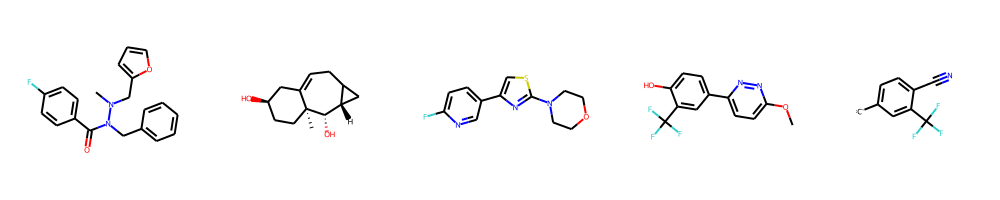

In [73]:
generated_smiles = set(smiles)
original_smiles = set(data["canonical_smiles"])

new_smiles = generated_smiles.difference(original_smiles)
new_molecules = [Chem.MolFromSmiles(smile) for smile in new_smiles]

Chem.Draw.MolsToGridImage(new_molecules[0:5], molsPerRow=5)

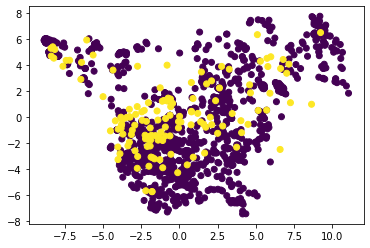

In [111]:
allsmiles = list(original_smiles) + list(generated_smiles)
labels = [0 for _ in range(len(original_smiles))] + [1 for _ in range(len(generated_smiles))]

RDKIT_FINGERPRINT_GENERATOR = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
FINGERPRINT_LENGTH = 2048

fingerprints = [RDKIT_FINGERPRINT_GENERATOR.GetFingerprint(Chem.MolFromSmiles(smile)) for smile in allsmiles]
fingerprints_array = np.zeros((len(fingerprints), FINGERPRINT_LENGTH))

for idx, fingerprint in enumerate(fingerprints):
    fingerprints_array[idx] = np.array(fingerprint)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(fingerprints_array)

plt.scatter(x=reduced_data[:,0], y=reduced_data[:,1], c=labels)
plt.show()